In [1]:
%matplotlib inline 
from plantcv import plantcv as pcv
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import img_as_ubyte
from skimage.exposure import adjust_gamma
import pandas as pd

In [2]:
pcv.params.debug = None # turn off plotting while reading in the image cube 
pcv.params.dpi = 125

## Input data

In [3]:
infile = "imgs/PSII_HDR_032321_TEST_1.INF"

In [4]:
# Read fluorescence image data

# Inputs:
#   filename - Image file to be read in (should be an .INF file)
ps = pcv.photosynthesis.read_cropreporter(filename=infile)

Compiling: PSD
Compiling: PSL
Compiling: CHL
Compiling: CLR
Compiling: SPC


### Print what data were imported

In [5]:
print(ps)

PSII variables defined:
darkadapted
lightadapted
spectral
chlorophyll
datapath
filename


## Create a mask

In [6]:
#make fmin for masking
pcv.params.debug = "plot" # turn plotting back on to see debug images 

fmin = ps.darkadapted.sel(frame_label="F0").data.squeeze() # pull out the F0 frame 

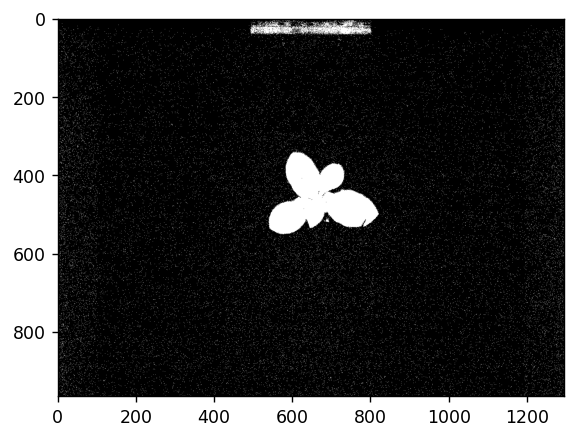

In [7]:
# Threshold the `fmin` image

# Inputs:
#   gray_img        - Grayscale image data
#   threshold       - Threshold value (usually between 0-255)
#   max_value       - Value to apply above threshold (255 = white)
#   object_type     - 'light' (default) or 'dark'. If the object is lighter than the
#                       background then standard threshold is done. If the object is
#                       darker than the background then inverse thresholding is done.
plant_mask = pcv.threshold.binary(gray_img=fmin, threshold=250, max_value=256, object_type="light")

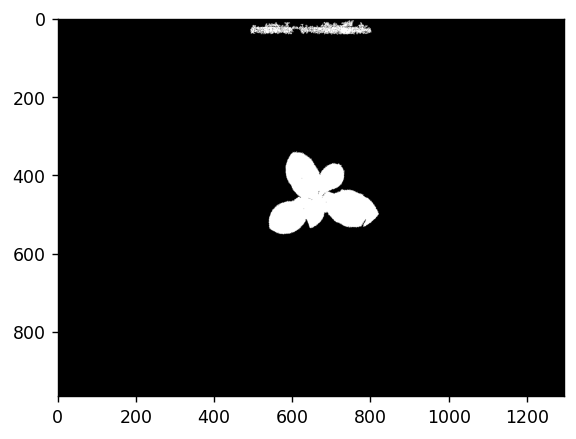

In [8]:
# Fill small objects

# Inputs:
#   bin_img         - Binary image data
#   size            - Minimum object area size in pixels (integer), smaller objects get filled in.
filled_mask = pcv.fill(bin_img=plant_mask, size=200)

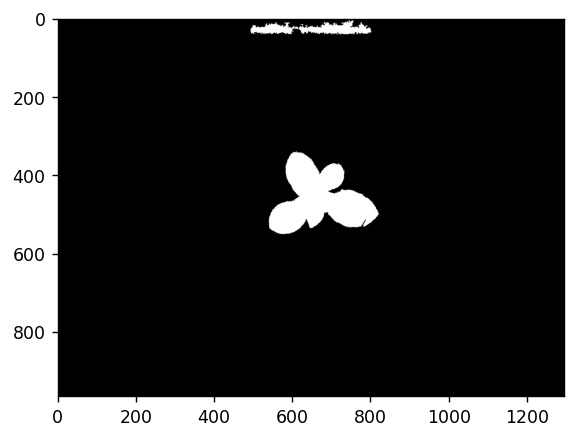

In [9]:
# Fill small objects

# Inputs:
#   bin_img         - Binary image data
mask = pcv.fill_holes(bin_img=filled_mask)

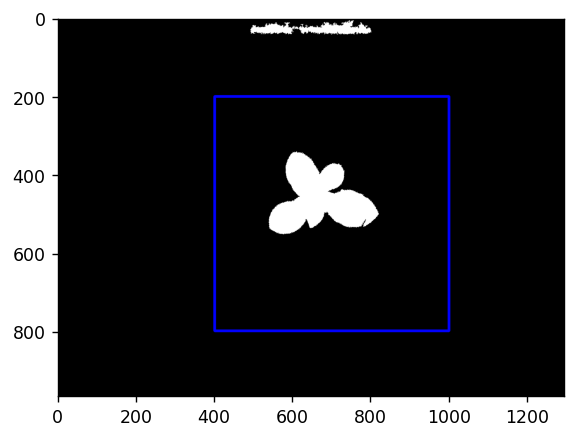

In [10]:
# Define ROI

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=mask, x=400, y=200, h=600, w=600)

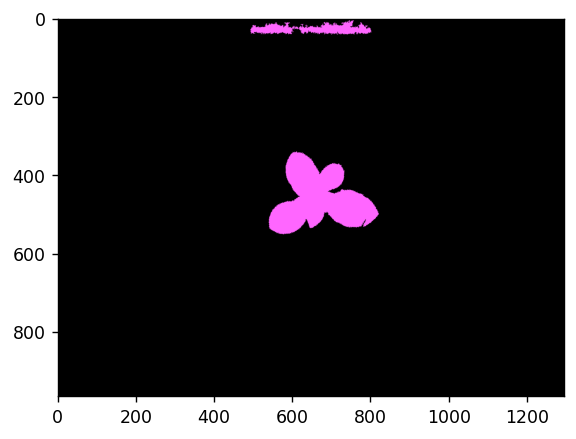

In [11]:
# Identify objects

# Inputs:
#   img             - RGB or grayscale image data for plotting
#   mask            - Binary mask used for detecting contours
plant_obj, plant_hier = pcv.find_objects(img=mask, mask=mask)

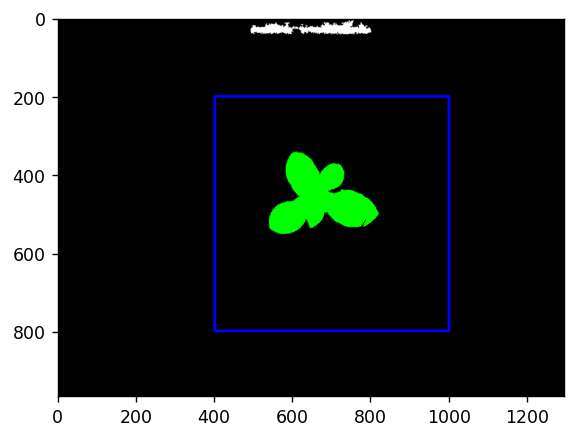

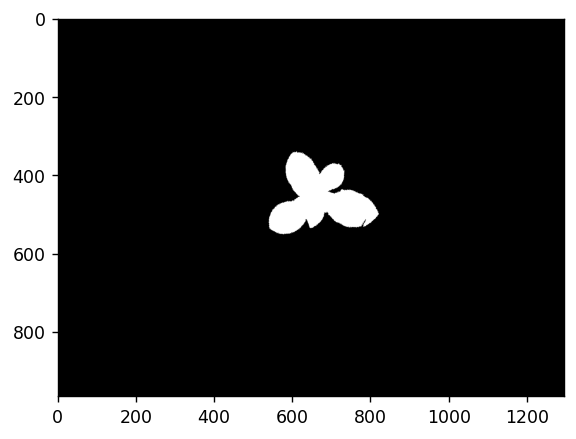

In [12]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
objects, hier, filtered_mask, obj_area = pcv.roi_objects(img=mask, roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                     object_contour=plant_obj, obj_hierarchy=plant_hier, roi_type='partial')

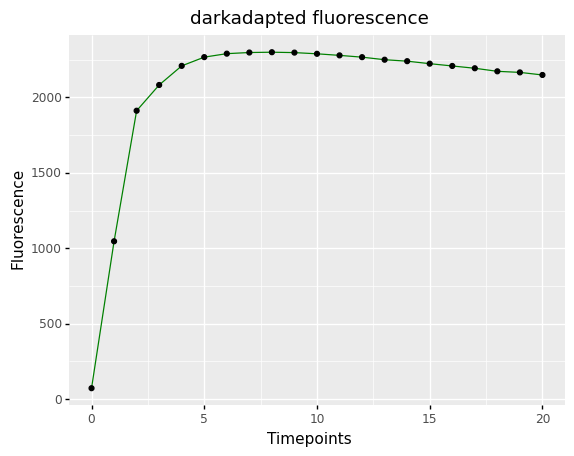

In [13]:
# Reassign frames 

# Inputs:
#    ps_da          = photosynthesis xarray DataArray
#    mask           = mask of plant (binary, single channel)

da, ind_fig, ind_df = pcv.photosynthesis.reassign_frame_labels(ps_da=ps.darkadapted, mask=filtered_mask)

Analyze individual frames by using the `analyze_nir_intensity` function. This function plots and stores pixel intensity values for any grayscale image. Utilizing the `label` parameter allows for using this function multiple times within a workflow. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


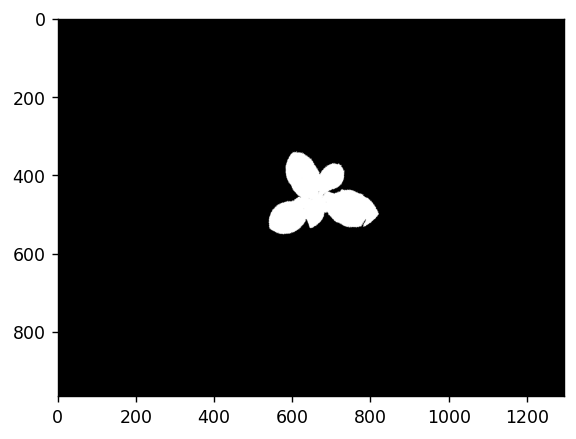

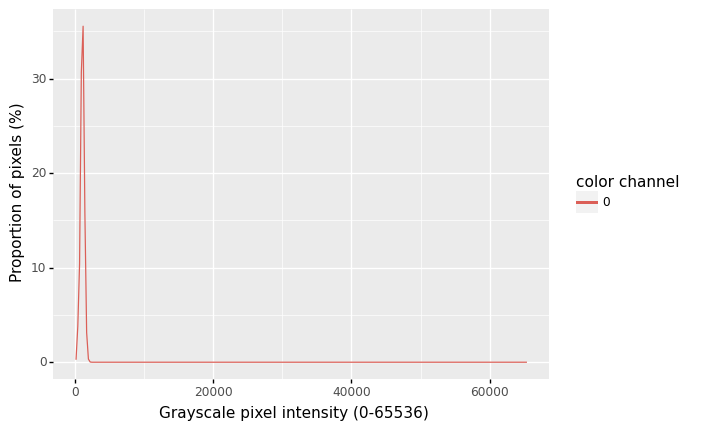

In [14]:
# Perform NIR signal analysis 

# Inputs: 
#   gray_img - 8 or 16-bit grayscale image data 
#   mask - Binary mask made from selected contours 
#   bins - Number of classes to divide the spectrum into 
#   histplot - If True, plots the histogram of intensity values 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

f0_hist = pcv.analyze_nir_intensity(gray_img=da.sel(frame_label="F0").data, mask=filtered_mask, label="F0")

Data is automatically stored into the outputs observations, but these are always accessible during a workflow by calling the dictionary. 

In [15]:

pcv.outputs.observations["F0"]["nir_median"]["value"]

1055.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


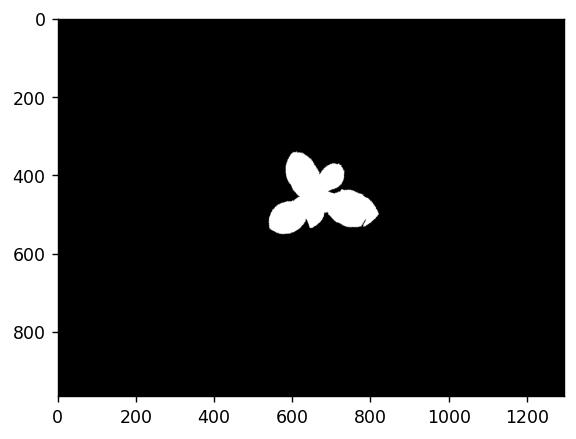

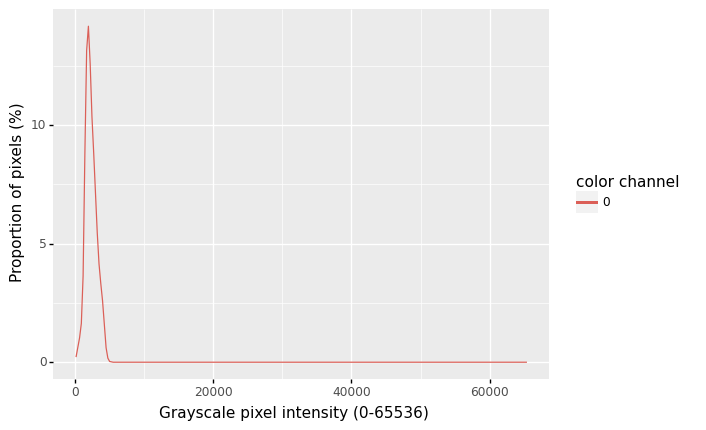

In [16]:
fm_hist = pcv.analyze_nir_intensity(gray_img=da.sel(frame_label="Fm").data, mask=filtered_mask, label="Fm")

In [17]:
pcv.outputs.observations["Fm"]["nir_median"]["value"]

2180.0

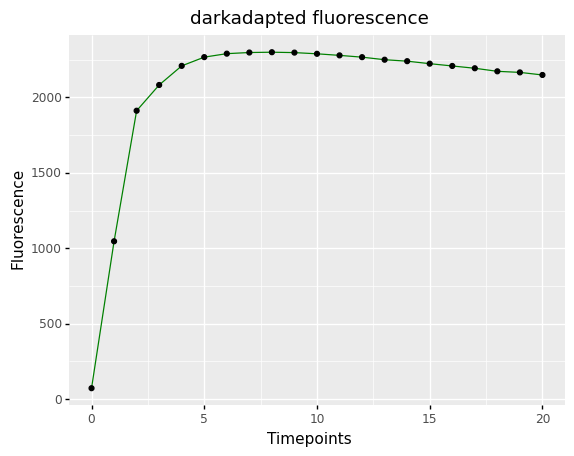

In [18]:
dark_da, dark_fig, dark_df = pcv.photosynthesis.reassign_frame_labels(ps_da=ps.darkadapted, mask=filtered_mask)

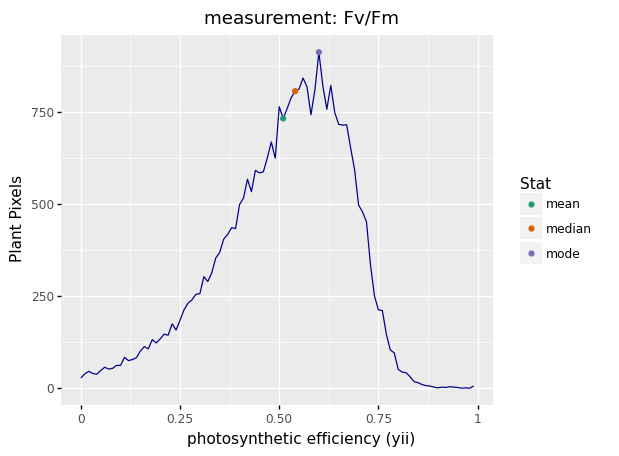

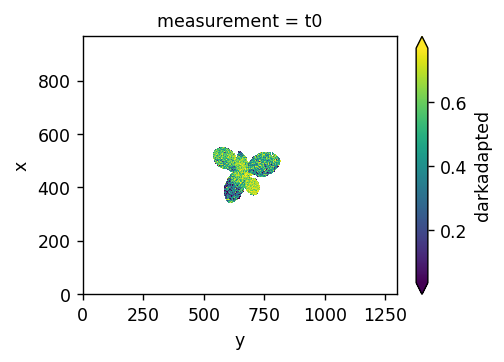

In [19]:
fvfm, fvfm_hist = pcv.photosynthesis.analyze_yii(ps_da=dark_da, mask=filtered_mask, measurement_labels=["Fv/Fm"])


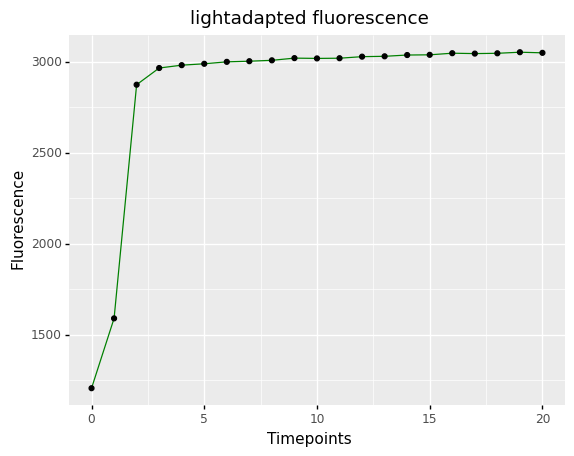

In [20]:
light_da, light_fig, light_df = pcv.photosynthesis.reassign_frame_labels(ps_da=ps.lightadapted, mask=filtered_mask)

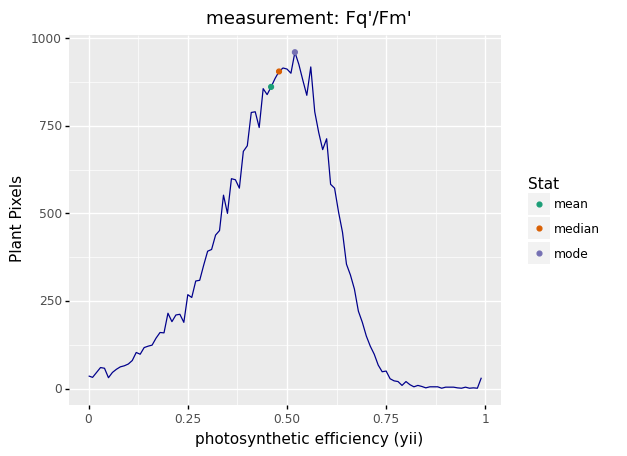

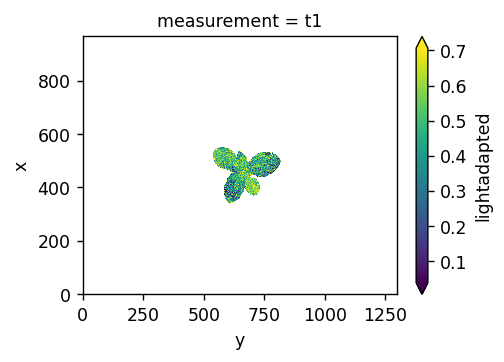

In [21]:
fqfm, fqfm_hist = pcv.photosynthesis.analyze_yii(ps_da=light_da, mask=filtered_mask, measurement_labels=["Fq'/Fm'"])

Extract the CI red edge index from the data cube using the `spectral index` sub-package. The input for this function is most commonly a hyperspectral datacube, but this index can also be calculated from the frames availble in a photosynthesis image dataset. The PSII data that gets input here is the subset of frames that are labeled "spectral" and get called with the code `ps.spectral` since our whole PSII data cube is stored in a variable called `ps`. 

/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:194: RuntimeWarning: divide by zero encountered in true_divide
/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:194: RuntimeWarning: invalid value encountered in true_divide


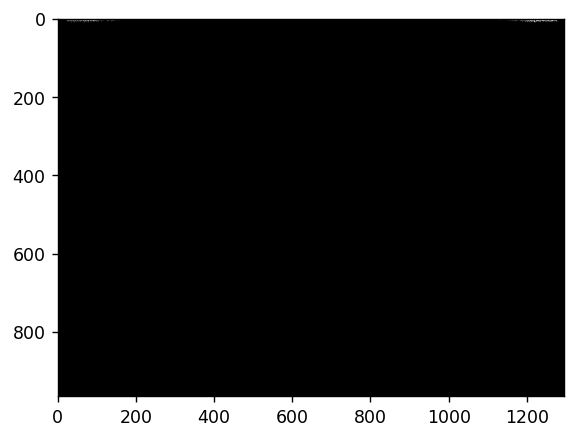

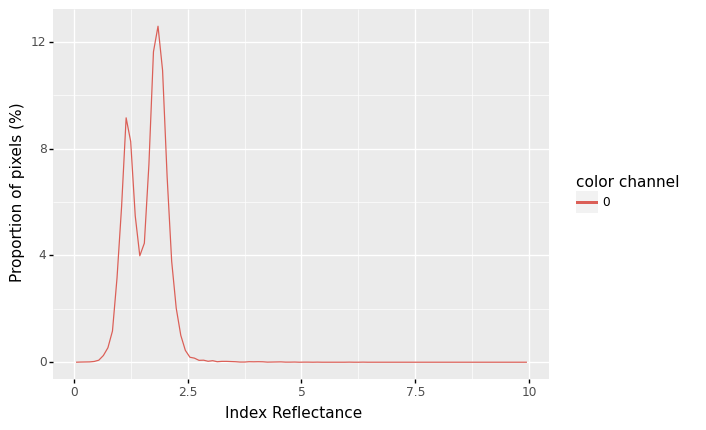

In [22]:
# Extract the CI red edge index 

# Inputs: 
#   hsi         = hyperspectral image (PlantCV Spectral_data instance)
ci = pcv.spectral_index.ci_rededge(hsi=ps.spectral)

# Inputs: 
#   index_array = hyperspectral image (PlantCV Spectral_data instance)
#   mask        = Binary mask made from selected contours
#   histplot    = if True plots histogram of intensity values
#   bins        = optional, number of classes to divide spectrum into
#   min_bin     = optional, minimum bin value ("auto" or user input minimum value)
#   max_bin     = optional, maximum bin value ("auto" or user input maximum value)
#   label       = optional label parameter, modifies the variable name of observations recorded
ci_hist = pcv.hyperspectral.analyze_index(index_array=ci, mask=filtered_mask, min_bin=0, max_bin=10)

/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:163: RuntimeWarning: divide by zero encountered in true_divide
/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:163: RuntimeWarning: invalid value encountered in subtract


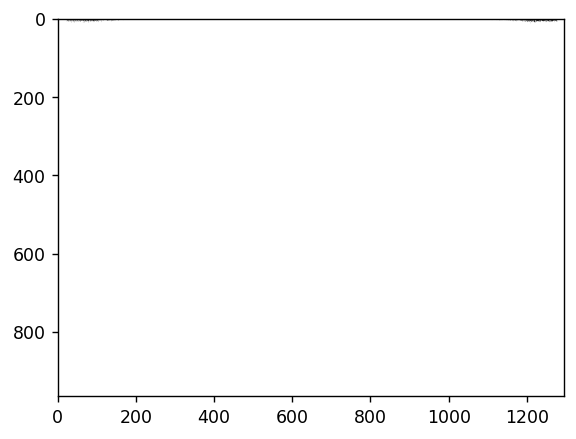

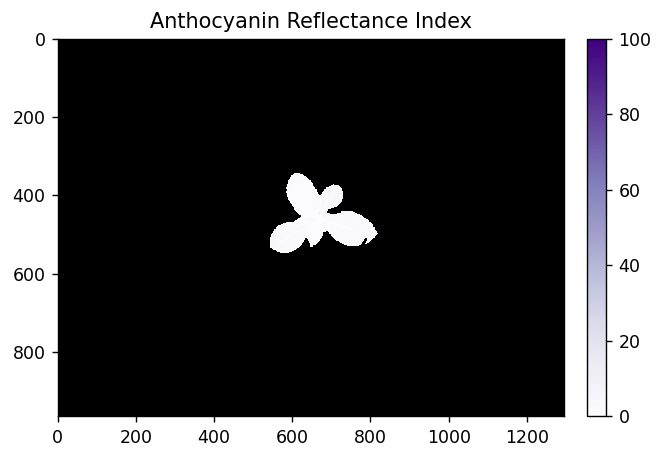

WARNING!!! The observed range of pixel values in your masked index provided is [-20.91291, 72.74458] but the user defined range of bins for pixel frequencies is [0, 100]. Adjust min_bin and max_bin in order to avoid cutting off data being collected.


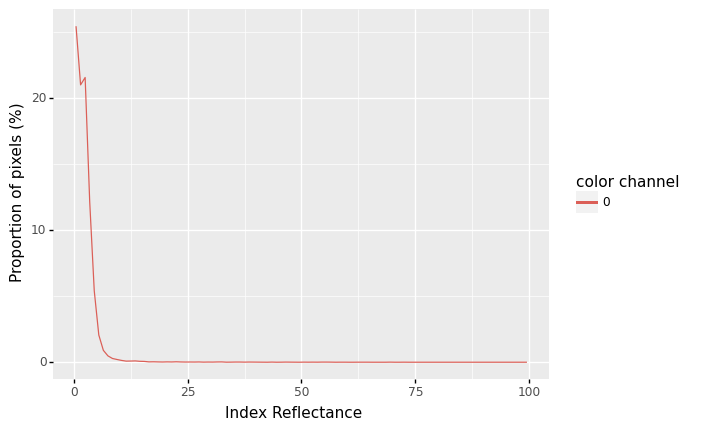

In [23]:
ari = pcv.spectral_index.ari(hsi=ps.spectral)

ari_ps = pcv.visualize.pseudocolor(gray_img=ari.array_data, min_value=0, max_value=100, 
                                    cmap="Purples", mask=filtered_mask, background="black", 
                                    title="Anthocyanin Reflectance Index")
ari_hist = pcv.hyperspectral.analyze_index(index_array=ari, mask=filtered_mask, min_bin=0, max_bin=100)


/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:40: RuntimeWarning: invalid value encountered in true_divide


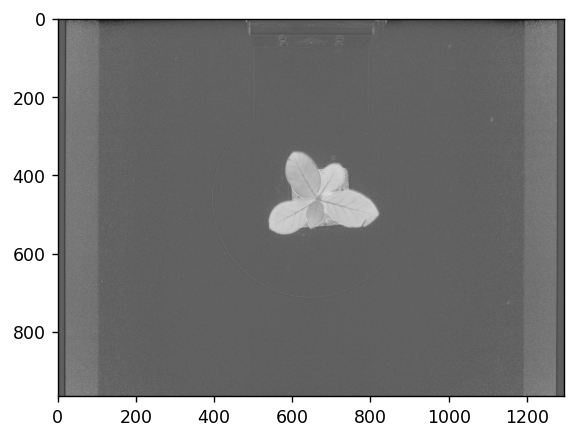

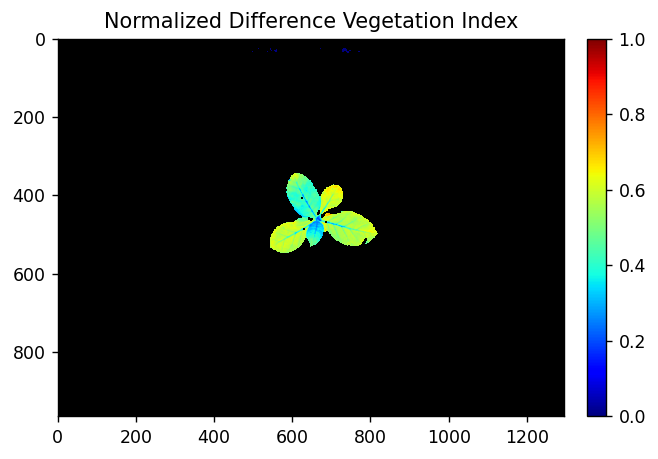

WARNING!!! The observed range of pixel values in your masked index provided is [-0.1370955, 0.8215103] but the user defined range of bins for pixel frequencies is [0, 1]. Adjust min_bin and max_bin in order to avoid cutting off data being collected.


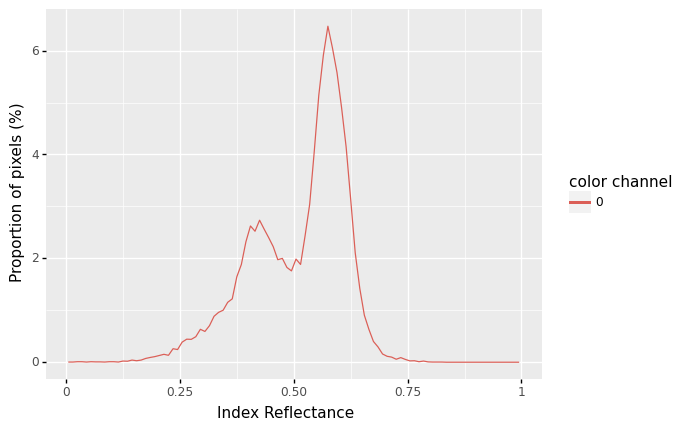

In [24]:
ndvi = pcv.spectral_index.ndvi(hsi=ps.spectral)

ndvi_ps = pcv.visualize.pseudocolor(gray_img=ndvi.array_data, min_value=0, max_value=1, 
                                        cmap="jet", mask=filled_mask, background="black", 
                                        title="Normalized Difference Vegetation Index")

ndvi_hist = pcv.hyperspectral.analyze_index(index_array=ndvi, mask=filtered_mask, min_bin=0, max_bin=1)
